# Segmenting and Clustering Sao Paulo Subway Stations 

At this notebook, Foursquare API was used to cluster subway station (Metro) neighborhoods in Sao Paulo regarding closely venues. The amount of venues per category in each subway station was acquired by a HTTP request to Foursquare API, and then used to group the stations into clusters. For this notebook *k*-means clustering algorithm was selected to complete this task. Finally, Folium library has been used to visualize the neighborhoods in Sao Paulo and their emerging clusters.

---
##  Introduction
---

The São Paulo Subway, commonly called the Metro is one of the urban railways that serves the city of São Paulo, alongside the São Paulo Metropolitan Trains Company (CPTM), forming the largest metropolitan rail transport network of Latin America. The six lines in the metro system operate on 101.1 kilometres (62.8 mi) of route, serving 72 stations. The metro system carries about 5,300,000 passengers a day.

Metro itself is far from covering the entire urban area in the city of São Paulo and only runs within the city limits. However, it is complemented by a network of metropolitan trains operated by CPTM, which serve the São Paulo and the São Paulo Metropolitan Region. The two systems combined form a 374 km (232 mi) long network.

Undoubtedly, subway is an important part of any metropolis around the world. The idea of this project is to categorically segment the neighborhoods of Sao Paulo into major clusters and examine their surrounding. A desirable intention is to examine the neighborhood cluster's profile, some neighborhoods are mostly residential, others have more business or commercial spaces. This project will help to understand the diversity of a subway station by leveraging venue data from Foursquare’s ‘Places API’ and ‘k-means clustering’ unsupervised machine learning algorithm. By analyzing this data we can classify stations by their primary usage. This data can be useful for city planners to determine where from and where to people are most likely to travel for work and leisure, plan further extension of the network and find places for new development.

---
## 1. Setup
---

At this first part, all code below is used to setup all libraries and settings from Notebook

### 1.1 Import Libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import requests
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from configparser import ConfigParser
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from sklearn.preprocessing import MinMaxScaler
from IPython.core.display import display, HTML

### 1.2 Notebook Settings

In [10]:
# Show all Columns and Rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Larger Kernels on Jupyter Notebook
display(HTML('<style>.container{width: 90% !important;}</style>' ))

---
## 2. Data
---

All data for subway stations (Metro) was downloaded from [Kaggle](https://www.kaggle.com/thiagodsd/sao-paulo-metro/kernels). After getting all data from Metro it was merged with Foursquare data, a location data provider. At this notebook will be used RESTful API calls to retrieve data about venues in different areas. This is the link to [Foursquare API](https://developer.foursquare.com/docs) documentation for more details.

### 2.1 Subway Station Data

In order to segment the metro station of Sao Paulo, a dataset of coordinates (latitude and longitude) for all subway stations this dataset was downloaded from [Kaggle](https://www.kaggle.com/thiagodsd/sao-paulo-metro/kernels). Once the .csv file is downloaded and transformed into pandas dataframe, which is basically a table with the metro stations and coordinates. After this step, was performed a basic clean up (renaming columns and dropping other's). 

Upon analysis, it is found that the dataframe consists of 79 metro stations. Further, ‘geopy’ library is used to get the latitude and longitude values of Sao Paulo, which was returned to be **Latitude: -23.5506507, Longitude: -46.6333824**. The curated dataframe is then used to visualize by creating a map of Sao Paulo with metro station superimposed on top. The following map was generated using python ‘folium’ library. 

#### Reading

In [46]:
metro_data = pd.read_csv('../data/metrosp_stations.csv', low_memory=False)
metro_data.head()

,Unnamed: 0,name,station,lat,lon,line,neigh
0,aacd-servidor,Aacd Servidor,aacd-servidor,-23.597825,-46.652374,['lilas'],"['moema', 'hospital-sao-paulo']"
1,adolfo-pinheiro,Adolfo Pinheiro,adolfo-pinheiro,-23.650073,-46.704206,['lilas'],"['largo-treze', 'alto-da-boa-vista']"
2,alto-da-boa-vista,Alto Da Boa Vista,alto-da-boa-vista,-23.641625,-46.699434,['lilas'],"['adolfo-pinheiro', 'borba-gato']"
3,alto-do-ipiranga,Alto Do Ipiranga,alto-do-ipiranga,-23.602237,-46.612486,['verde'],"['santos-imigrantes', 'sacoma']"
4,ana-rosa,Ana Rosa,ana-rosa,-23.581871,-46.638104,"['azul', 'verde']","['paraiso', 'vila-mariana', 'paraiso', 'chacar..."


#### Cleaning

In [47]:
# Renaming columns
new_columns = ['unnamed',
              'station_name_spaced',
               'station_name',
               'latitude',
               'longitude',
               'metro_line',
               'neigh_stations']

metro_data.columns = new_columns

# Selecting columns
metro_data = metro_data.drop(columns=['unnamed', 'neigh_stations', 'station_name_spaced', 'metro_line'])

# Data Head
metro_data.head()

,station_name,latitude,longitude
0,aacd-servidor,-23.597825,-46.652374
1,adolfo-pinheiro,-23.650073,-46.704206
2,alto-da-boa-vista,-23.641625,-46.699434
3,alto-do-ipiranga,-23.602237,-46.612486
4,ana-rosa,-23.581871,-46.638104


#### Visualization

In [49]:
metro_data.shape

(79, 3)

In [52]:
address = 'Sao Paulo, Sao Paulo Brazil'
geolocator = Nominatim(user_agent='get_location')

latitude = geolocator.geocode(address).latitude
longitude = geolocator.geocode(address).longitude

city_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, metro_station, metro_line in zip(metro_venues['latitude']
                                               , metro_venues['longitude']
                                               , metro_venues['metro_station']
                                               , metro_venues['metro_line']):
    
    label = '{}, {}'.format(metro_station, metro_line)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                            [lat, lng],
                            radius=5,
                            popup=label,
                            color='blue',
                            fill=True,
                            fill_color='#3186cc',
                            fill_opacity=0.7,
                            parse_html=False
                        ).add_to(city_map)  
    
city_map

### 2.2 Venues and Categories Data from Foursquare API

In order to find and explore venues and categories surrounding each station, it has been used Foursquare API. Venues can be categorized as residential, professional, shopping or leisure. Let's see what venue categories Foursquare identifies.

Following example of a response from Foursquare API

``` json
{'categories': [{'id': '4d4b7104d754a06370d81259',
'name': 'Arts & Entertainment',
'pluralName': 'Arts & Entertainment',
'shortName': 'Arts & Entertainment',
'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
'suffix': '.png'},
'categories': [{'id': '56aa371be4b08b9a8d5734db',
'name': 'Amphitheater',
'pluralName': 'Amphitheaters',
'shortName': 'Amphitheater',
'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
'suffix': '.png'},
'categories': []},
{'id': '4fceea171983d5d06c3e9823',
'name': 'Aquarium',
'pluralName': 'Aquariums',
'shortName': 'Aquarium',
'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
'suffix': '.png'},
'categories': []}]
```

As mentioned Foursquare API is used to explore the metro station surrounding and segment them. To access the API, ‘CLIENT_ID’, ‘CLIENT_SECRET’ and ‘VERSION’ is defined in a credentials file, in order to get a credentials as well just sign up on the following [link](https://developer.foursquare.com/).

There are many endpoints available on Foursquare for various GET requests. But, to explore the subway surrounding, it is required the amount of venues per category establish at Foursquare Venue Category Hierarchy, which is retrieved using the code below.

#### Getting Credentials for Foursquare API

In [5]:
def get_credentials():
    ''' Function return credentials from .ini file '''
    
    credentials = {}
    parser = ConfigParser()
    
    parser.read(str(Path.home()) + "/.config/credentials.ini")

    if parser.has_section('foursquare'):
        items = parser.items('foursquare')
        
        for item in items:
            credentials[item[0]] = item[1]
            
        print('Credentials were load successfully')
      
    else:
        print('Credentials were not found')

    return credentials

credentials = get_credentials()

Credentials were load successfully


#### Get Response from Foursquare API

In [6]:
# GET Response from Foursquare API
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            credentials['client_id'], 
            credentials['client_secret'], 
            credentials['version'])
            
# make the GET request
category_results = requests.get(categories_url).json()
category_results = category_results['response']['categories']

#### Categories

Upon analysis, it is found that there are 10 major or parent categories of venues,
under which all the other sub-categories are included. Following depiction shows
the ‘Category ID’ and ‘Category Name’ retrieved from API 

In [7]:
# Transforming Json to DataFrame
categories = pd.json_normalize(data=category_results)

# Cleaning DataFrame
categories = categories.drop(columns=['pluralName'
                             ,'shortName'
                             ,'categories'
                             ,'icon.prefix'
                             ,'icon.suffix'])

categories = categories.rename(columns={'id':'category_id',
                                         'name':'category_name'})
categories

,category_id,category_name
0,4d4b7104d754a06370d81259,Arts & Entertainment
1,4d4b7105d754a06372d81259,College & University
2,4d4b7105d754a06373d81259,Event
3,4d4b7105d754a06374d81259,Food
4,4d4b7105d754a06376d81259,Nightlife Spot
5,4d4b7105d754a06377d81259,Outdoors & Recreation
6,4d4b7105d754a06375d81259,Professional & Other Places
7,4e67e38e036454776db1fb3a,Residence
8,4d4b7105d754a06378d81259,Shop & Service
9,4d4b7105d754a06379d81259,Travel & Transport


#### Number of venues per category

As said earlier, the amount of venues per category for each subway station depiction is the matter of interest. A function is created to return a dataframe with ‘Category ID’, ‘Category Name’ and ‘Venues Quantity’ per ‘Metro Station’. 

The function ‘get_venues_total’ is created. This functions loop through all the subway stations of Sao Paulo and creates an API request URL with radius = 100. Further, the GET request is made to Foursquare API and the data is then appended to a python dataframe. Lastly, the python dataframe is returned by the function.

In [8]:
def get_venues_total(credentials, lat, long, radius, category_id): 
    ''' Function which returns number of venues considering a Foursquare cateogry and radius '''
    
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                      credentials['client_id'], 
                      credentials['client_secret'], 
                      credentials['version'], 
                      lat,
                      long,
                      radius,
                      category_id)
  
    try:
        response = requests.get(explore_url).json()['response']['totalResults']
  
    except:
        response = 0
        
    return response

In [9]:
metro_venues = []

for index, metro in metro_data.iterrows():
    for index_2, category in categories.iterrows():
        metro_venues.append([(  metro['station_name']
                                , metro['latitude']
                                , metro['longitude']
                                , metro['metro_line']
                                , category['category_name'] 
                                , get_venues_total(credentials = credentials
                                                   ,lat = metro['latitude']
                                                   ,long = metro['longitude']
                                                   ,radius = 1000
                                                   ,category_id = category['category_id']))])
    
metro_venues = pd.DataFrame([item for metro_venues in metro_venues for item in metro_venues])
metro_venues.columns=['metro_station', 'latitude', 'longitude', 'metro_line', 'category_name', 'venues']

# Exporting to .CSV
metro_venues.to_csv('../data/results_from_api.csv', index=False)
metro_venues.tail()

,metro_station,latitude,longitude,metro_line,category_name,venues
785,vila-uniao,-23.602966,-46.515567,['prata'],Outdoors & Recreation,1
786,vila-uniao,-23.602966,-46.515567,['prata'],Professional & Other Places,11
787,vila-uniao,-23.602966,-46.515567,['prata'],Residence,0
788,vila-uniao,-23.602966,-46.515567,['prata'],Shop & Service,8
789,vila-uniao,-23.602966,-46.515567,['prata'],Travel & Transport,2


---
## 3. Exploratory Data Analysis (EDA)
---

In [13]:
metro_venues = pd.read_csv('../data/results_from_api.csv')

### 3.1 Descriptive Analysis

As noticed on the figures below **Food, Professional & Other Places and Shop & Service** appears in more quantity then other categories .  

In [32]:
metro_venues.groupby('category_name')['venues'].describe().T.round()

category_name,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
mean,22.0,37.0,4.0,125.0,35.0,45.0,94.0,21.0,91.0,31.0
std,21.0,23.0,4.0,63.0,34.0,24.0,45.0,14.0,43.0,30.0
min,2.0,2.0,0.0,26.0,4.0,7.0,32.0,0.0,32.0,2.0
25%,6.0,17.0,2.0,72.0,12.0,25.0,54.0,10.0,61.0,10.0
50%,15.0,34.0,3.0,110.0,23.0,39.0,86.0,20.0,79.0,19.0
75%,33.0,54.0,5.0,174.0,45.0,64.0,133.0,26.0,113.0,44.0
max,86.0,86.0,18.0,243.0,124.0,102.0,183.0,67.0,180.0,111.0


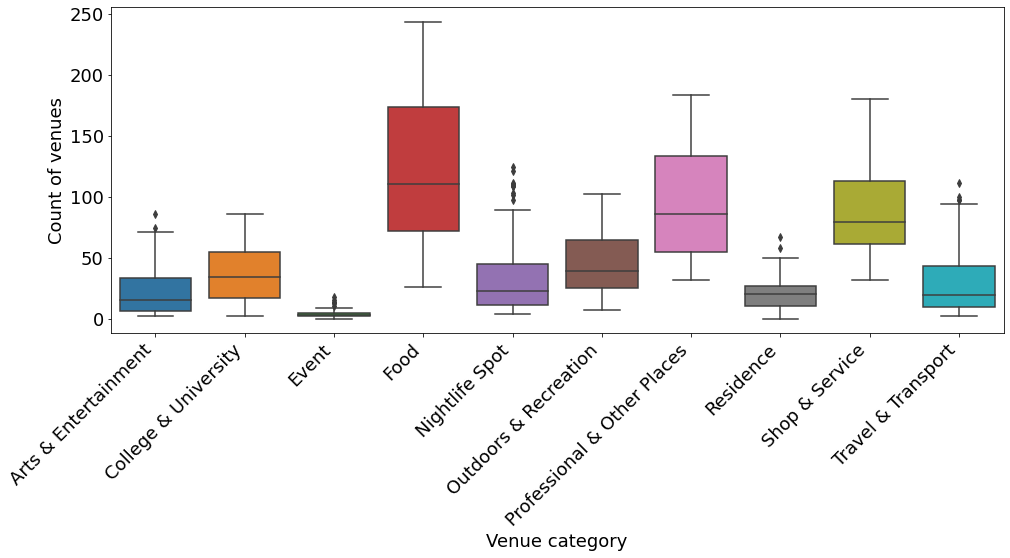

In [20]:
plt.figure(figsize=(16, 6))

ax = sns.boxplot(x="category_name", y="venues", data=metro_venues)
ax.set_ylabel('Count of venues', fontsize=18)
ax.set_xlabel('Venue category', fontsize=18)
ax.tick_params(labelsize=18)
plt.xticks(rotation=45, ha='right')

plt.show()

In [21]:
df = pd.pivot_table(metro_venues
                    , index=['metro_station', 'metro_line','latitude', 'longitude']
                    , columns='category_name'
                    , values='venues', ).reset_index()

df = df.rename_axis(None, axis=1)
df.head()

,metro_station,metro_line,latitude,longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,aacd-servidor,['lilas'],-23.597825,-46.652374,13,71,3,110,23,76,121,11,62,23
1,adolfo-pinheiro,['lilas'],-23.650073,-46.704206,8,42,0,96,11,33,89,14,89,15
2,alto-da-boa-vista,['lilas'],-23.641625,-46.699434,2,24,2,71,8,30,90,15,65,9
3,alto-do-ipiranga,['verde'],-23.602237,-46.612486,10,23,2,68,12,43,47,33,58,5
4,ana-rosa,"['azul', 'verde']",-23.581871,-46.638104,32,75,7,214,55,68,136,29,94,47


### 3.3 Feature Engineering

In [22]:
cluster_dataset = df.iloc[:,4:]
category_list = cluster_dataset.columns

X = cluster_dataset.values
cluster_dataset = pd.DataFrame(MinMaxScaler().fit_transform(X))
cluster_dataset.columns = category_list

cluster_dataset = cluster_dataset.reset_index(drop=True)
cluster_dataset.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.130952,0.821429,0.166667,0.387097,0.158333,0.726316,0.589404,0.164179,0.202703,0.192661
1,0.071429,0.476190,0.000000,0.322581,0.058333,0.273684,0.377483,0.208955,0.385135,0.119266
2,0.000000,0.261905,0.111111,0.207373,0.033333,0.242105,0.384106,0.223881,0.222973,0.064220
3,0.095238,0.250000,0.111111,0.193548,0.066667,0.378947,0.099338,0.492537,0.175676,0.027523
4,0.357143,0.869048,0.388889,0.866359,0.425000,0.642105,0.688742,0.432836,0.418919,0.412844


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

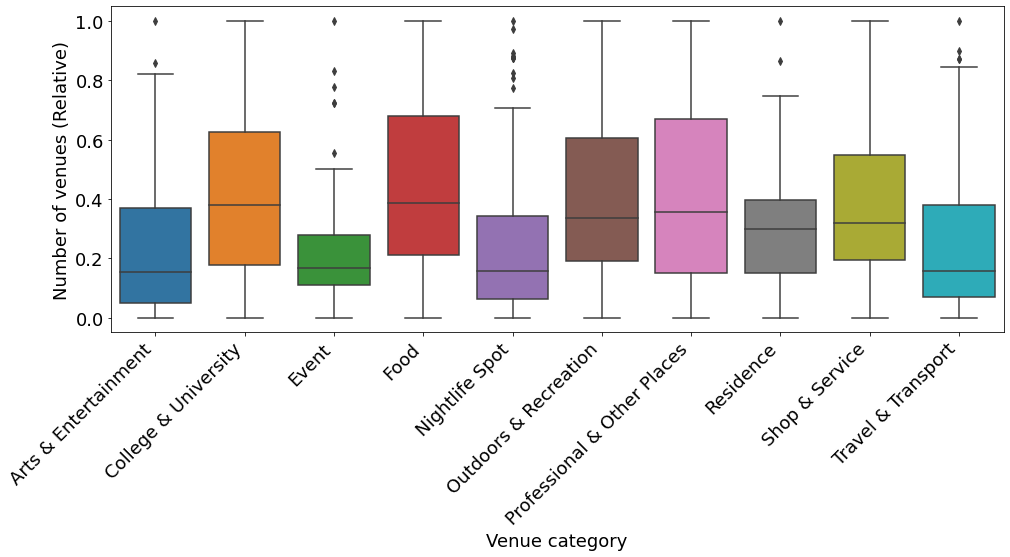

In [23]:
plt.figure(figsize=(16, 6))

ax = sns.boxplot(data=cluster_dataset)
ax.set_ylabel('Number of venues (Relative)', fontsize=18)
ax.set_xlabel('Venue category', fontsize=18)
ax.tick_params(labelsize=18)

plt.xticks(rotation=45, ha='right')

In [24]:
df_eda = cluster_dataset.copy()
df_eda['metro_station'] = df['metro_station']
df_eda.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,metro_station
0,0.130952,0.821429,0.166667,0.387097,0.158333,0.726316,0.589404,0.164179,0.202703,0.192661,aacd-servidor
1,0.071429,0.476190,0.000000,0.322581,0.058333,0.273684,0.377483,0.208955,0.385135,0.119266,adolfo-pinheiro
2,0.000000,0.261905,0.111111,0.207373,0.033333,0.242105,0.384106,0.223881,0.222973,0.064220,alto-da-boa-vista
3,0.095238,0.250000,0.111111,0.193548,0.066667,0.378947,0.099338,0.492537,0.175676,0.027523,alto-do-ipiranga
4,0.357143,0.869048,0.388889,0.866359,0.425000,0.642105,0.688742,0.432836,0.418919,0.412844,ana-rosa


---
## 4. Modeling
---

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

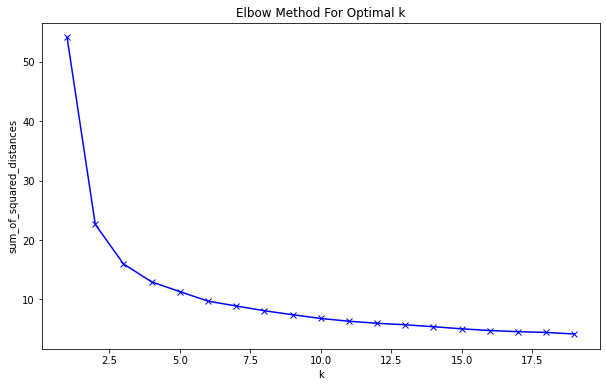

In [33]:
sum_of_squared_distances = []
K = range(1,20)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20).fit(cluster_dataset)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [34]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=20).fit(cluster_dataset)

kmeans_labels = kmeans.labels_

df_clusters = df.copy()
df_clusters['cluster'] = kmeans_labels

df_clusters_minmax = cluster_dataset.copy()
df_clusters_minmax['cluster'] = kmeans_labels
df_clusters_minmax['metro_station'] = df['metro_station']
df_clusters_minmax['latitude'] = df['latitude']
df_clusters_minmax['longitude'] = df['longitude']

df_clusters_minmax.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,cluster,metro_station,latitude,longitude
0,0.130952,0.821429,0.166667,0.387097,0.158333,0.726316,0.589404,0.164179,0.202703,0.192661,2,aacd-servidor,-23.597825,-46.652374
1,0.071429,0.476190,0.000000,0.322581,0.058333,0.273684,0.377483,0.208955,0.385135,0.119266,1,adolfo-pinheiro,-23.650073,-46.704206
2,0.000000,0.261905,0.111111,0.207373,0.033333,0.242105,0.384106,0.223881,0.222973,0.064220,1,alto-da-boa-vista,-23.641625,-46.699434
3,0.095238,0.250000,0.111111,0.193548,0.066667,0.378947,0.099338,0.492537,0.175676,0.027523,1,alto-do-ipiranga,-23.602237,-46.612486
4,0.357143,0.869048,0.388889,0.866359,0.425000,0.642105,0.688742,0.432836,0.418919,0.412844,2,ana-rosa,-23.581871,-46.638104


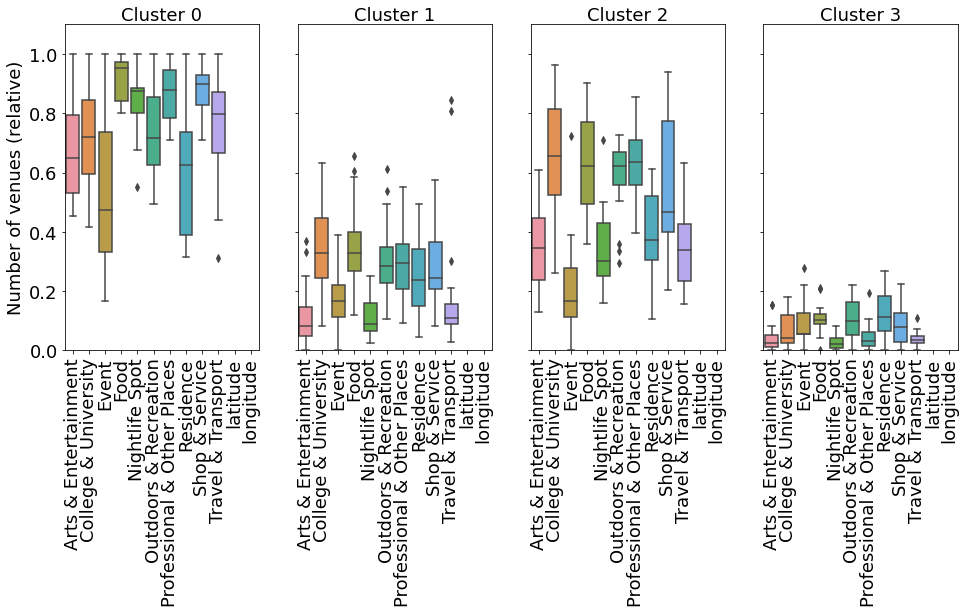

In [35]:
fig, axes = plt.subplots(1, kclusters, figsize=(16, 6), sharey=True )

axes[0].set_ylabel('Number of venues (relative)', fontsize=18)

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=18, )
    axes[k].tick_params(labelsize=18)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_clusters_minmax[df_clusters_minmax['cluster'] == k].drop('cluster',1), ax=axes[k])

plt.show()

In [37]:
address = 'Sao Paulo, Sao Paulo Brazil'
geolocator = Nominatim(user_agent='get_location')

latitude = geolocator.geocode(address).latitude
longitude = geolocator.geocode(address).longitude

categories_list = categories['category_name'].unique()

# set color scheme for the clusters
rainbow = ['#4c6ca5'
           , '#3c8447'
           , '#b40049'
           , '#864ca5']

city_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
markers_colors = []
for i, lat, lng, metro_station, cluster in zip(df_clusters_minmax.index
                                              , df_clusters_minmax['latitude']
                                              , df_clusters_minmax['longitude']
                                              , df_clusters_minmax['metro_station']
                                              , df_clusters_minmax['cluster']):
  
    #Calculate top 3 categories for each station
    station_series = df_clusters_minmax.iloc[i]
    top_categories_dict = {}

    for cat in categories_list:
        top_categories_dict[cat] = station_series[cat]
        
    top_categories = sorted(top_categories_dict.items(), key=lambda x: x[1], reverse=True)
  
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
          metro_station,
          cluster,
          top_categories[0][0],
          "{0:.2f}".format(top_categories[0][1]),
          top_categories[1][0],
          "{0:.2f}".format(top_categories[1][1]),
          top_categories[2][0],
          "{0:.2f}".format(top_categories[2][1]))
  
    label = folium.Popup(popup, parse_html=True)

    folium.CircleMarker(
                          [lat, lng],
                          radius=5,
                          popup=label,
                          color=rainbow[cluster-1],
                          fill=True,
                          fill_color=rainbow[cluster-1],
                          fill_opacity=0.7,
                          parse_html=False).add_to(city_map)  
    
city_map